In [1]:
import pandas as pd
from sklearn import preprocessing, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import json

from pickle import dump

In [2]:
# Import of cleaning functions
from cleaning59 import column_data_rate, column_data_rate_mean, common_elements, separate_elements 

In [3]:
# Import feature engineering module from a Kaggle script

# importing sys
import sys
  
# adding 'loan_customer_scoring' to the system path
sys.path.append('scripts\\loan_customer_scoring\\')

from data_aggregation import*

# DATA PREPARATION

### Data aggregation

In [4]:
df = main(part="train")

train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 23s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 21s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 17s


In [5]:
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train/validation split

In [6]:
# Defining the targets
y = df['TARGET']

In [7]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307507, dtype: int64

In [8]:
# Train/test split
df_train, df_val, y_train, y_val = \
	train_test_split(df, y,
                     test_size=0.3 # 30% of data for validation
                    ,random_state=1)

## Train part

### Data transformation

In [9]:
y_train

254597    0
298514    0
294495    0
116841    0
210739    0
         ..
21440     0
117586    0
73351     0
267340    0
128040    0
Name: TARGET, Length: 215254, dtype: int64

In [10]:
df_train

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
254597,394613,0,1,1,0,0,157500.0,325908.0,14485.5,247500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298514,445825,0,0,1,0,2,225000.0,540000.0,26109.0,540000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
294495,441180,0,1,0,0,0,94500.0,149256.0,15799.5,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116841,235496,0,1,0,0,0,175500.0,931500.0,30046.5,931500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210739,344210,0,0,0,1,0,135000.0,1185120.0,39298.5,900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21440,124980,0,1,0,0,1,292500.0,2013840.0,53253.0,1800000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
117586,236349,0,1,1,1,2,126000.0,296280.0,14382.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73351,185052,0,1,1,1,0,225000.0,927252.0,26703.0,774000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267340,409738,0,0,0,0,0,180000.0,1350000.0,50161.5,1350000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
y_val

292051    0
122561    0
196022    0
114506    0
246632    0
         ..
298163    0
106572    0
89212     0
110401    0
300918    0
Name: TARGET, Length: 92253, dtype: int64

In [12]:
df_val

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
292051,438333,0,1,0,0,0,315000.0,252000.0,19908.0,252000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
122561,242095,0,1,1,0,0,135000.0,1042560.0,34587.0,900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196022,327296,0,1,1,0,1,180000.0,270000.0,13500.0,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114506,232781,0,1,0,1,0,112500.0,728460.0,40675.5,675000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0
246632,385427,0,1,0,0,0,112500.0,622413.0,30073.5,495000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298163,445430,0,1,0,0,0,225000.0,983299.5,39127.5,904500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106572,223652,0,1,0,0,0,90000.0,119893.5,11988.0,103500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
89212,203581,0,1,0,0,0,112500.0,76410.0,7573.5,67500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110401,228060,0,1,0,1,0,135000.0,379008.0,44977.5,360000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Target removal from dataframes
df_train.drop(['TARGET'], axis=1, inplace=True)

In [14]:
# Set a new index with the loan ID 
df_train.set_index('SK_ID_CURR', inplace=True)

In [15]:
# Create arrays and dataframes to store results
feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# Modification of columns
df_train = df_train[feats]
df_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_train.columns]

### Data cleaning

In [16]:
# Check of infinite values

print("Infinite values detected: ")

for variable in df_train.columns:
    if len(np.isinf(df_train[variable]).value_counts())>1:
        print(f"\n{variable}")
        print(np.isinf(df_train[variable]).value_counts().iloc[1])
    else:
        None

Infinite values detected: 

PREV_APP_CREDIT_PERC_MAX
1

REFUSED_APP_CREDIT_PERC_MAX
1

INSTAL_PAYMENT_PERC_MAX
13


In [17]:
# Replacing infinte values by NaN
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

### Imputation

In [18]:
# Imputation

median_imputation_train = {}
zero_imputation_train = {}

for variable in df_train.columns:
    if df_train[variable].notna().mean() >= 0.65:
        median_value = df_train[variable].median()
        df_train.loc[df_train[variable].isna(), variable] = median_value
        
        # saving in a dictionnary
        median_imputation_train[variable] = median_value
        
        # saving in a json file
        tf = open("projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\cleaning\\dictionary_median_imputation_train.json", "w")
        json.dump(median_imputation_train,tf)
        tf.close()
        
    else:
        df_train.loc[df_train[variable].isna(), variable] = 0
        
        # saving in a dictionnary
        zero_imputation_train[variable] = 0
        
        # saving in a json file
        tf = open("projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\cleaning\\dictionary_zero_imputation_train.json", "w")
        json.dump(zero_imputation_train,tf)
        tf.close()

In [19]:
len(median_imputation_train)

548

In [20]:
len(zero_imputation_train)

247

In [21]:
# Filling rate by column
column_data_rate_mean(df_train)

1.0

## Validation part

### Data transformation

In [22]:
df_val.shape

(92253, 797)

In [23]:
df_val.dtypes.value_counts()

float64    621
uint8      133
int64       43
dtype: int64

In [24]:
# Filling rate by column
column_data_rate(df_val)

SK_ID_CURR                          1.000000
TARGET                              1.000000
CODE_GENDER                         1.000000
FLAG_OWN_CAR                        1.000000
FLAG_OWN_REALTY                     1.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.284143
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.284143
CC_NAME_CONTRACT_STATUS_nan_SUM     0.284143
CC_NAME_CONTRACT_STATUS_nan_VAR     0.282029
CC_COUNT                            0.284143
Length: 797, dtype: float64

In [25]:
# Mean filling rate by column
column_data_rate_mean(df_val)

0.741153456928036

In [26]:
# Set a new index with the loan ID 
df_val.set_index('SK_ID_CURR', inplace=True)

In [27]:
# Create arrays and dataframes to store results
feats = [f for f in df_val.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# Modification of columns
df_val = df_val[feats]
df_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_val.columns]

In [28]:
# Checking separate columns
separate_elements(df_train.columns, df_val.columns)

Liste 1: 795
Liste 2: 795


Separate elements: 


[]

In [29]:
df_val['NAME_FAMILY_STATUS_Unknown'] = 0
df_val['NAME_INCOME_TYPE_Maternity_leave'] = 0

C:\Users\vince\AppData\Local\Temp/ipykernel_24180/3062033780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['NAME_FAMILY_STATUS_Unknown'] = 0
C:\Users\vince\AppData\Local\Temp/ipykernel_24180/3062033780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['NAME_INCOME_TYPE_Maternity_leave'] = 0


In [30]:
df_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
394613,1,1,0,0,157500.0,325908.0,14485.5,247500.0,0.010966,-20855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
445825,0,1,0,2,225000.0,540000.0,26109.0,540000.0,0.028663,-11942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
441180,1,0,0,0,94500.0,149256.0,15799.5,135000.0,0.019101,-23753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235496,1,0,0,0,175500.0,931500.0,30046.5,931500.0,0.015221,-18209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344210,0,0,1,0,135000.0,1185120.0,39298.5,900000.0,0.004960,-13771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124980,1,0,0,1,292500.0,2013840.0,53253.0,1800000.0,0.025164,-13450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
236349,1,1,1,2,126000.0,296280.0,14382.0,225000.0,0.010556,-19028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185052,1,1,1,0,225000.0,927252.0,26703.0,774000.0,0.019101,-9509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Reordering columns
df_val = df_val[list(df_train.columns)]
df_val.shape

(92253, 795)

### Data cleaning

In [32]:
# Check of infinite values

print("Infinite values detected: ")

for variable in df_val.columns:
    if len(np.isinf(df_val[variable]).value_counts())>1:
        print(f"\n{variable}")
        print(np.isinf(df_val[variable]).value_counts().iloc[1])
    else:
        None

Infinite values detected: 

INSTAL_PAYMENT_PERC_MAX
5


In [33]:
# Replacing infinte values by NaN
df_val.replace([np.inf, -np.inf], np.nan, inplace=True)

### Imputation

In [34]:
# Imputation

median_imputation = []
zero_imputation = []

# loading median values from the training part from a json file
tf = open("projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\cleaning\\dictionary_median_imputation_train.json", "r")
median_imputation_train = json.load(tf)

for variable in df_val.columns:
    if df_val[variable].notna().mean() >= 0.65:
        if variable in median_imputation_train.keys():
        
            df_val.loc[df_val[variable].isna(), variable] = median_imputation_train[variable]
            median_imputation.append(variable)
        else:
            df_val.loc[df_val[variable].isna(), variable] = 0
        zero_imputation.append(variable)
            
    else:
        df_val.loc[df_val[variable].isna(), variable] = 0
        zero_imputation.append(variable)

In [35]:
# Mean filling rate by column
column_data_rate_mean(df_val)

1.0

In [36]:
len(median_imputation)

548

In [37]:
len(zero_imputation)

795

## Feature filtering

In [38]:
# Selection of features calculated previously with RFE
feature_list = ["PAYMENT_RATE", "EXT_SOURCE_2", "DAYS_BIRTH", "EXT_SOURCE_3", "AMT_ANNUITY", "ANNUITY_INCOME_PERC", "DAYS_ID_PUBLISH", "AMT_GOODS_PRICE", "AMT_CREDIT", "DAYS_REGISTRATION", "INSTAL_DAYS_ENTRY_PAYMENT_MAX", "PREV_CNT_PAYMENT_MEAN", "DAYS_LAST_PHONE_CHANGE", "DAYS_EMPLOYED_PERC", "BURO_DAYS_CREDIT_MAX", "INSTAL_AMT_PAYMENT_SUM", "INCOME_CREDIT_PERC", "INSTAL_AMT_PAYMENT_MIN", "ACTIVE_DAYS_CREDIT_ENDDATE_MIN", "CLOSED_DAYS_CREDIT_MAX", "BURO_DAYS_CREDIT_ENDDATE_MAX", "APPROVED_DAYS_DECISION_MAX", "INSTAL_DBD_SUM", "INSTAL_DBD_MAX", "INSTAL_DAYS_ENTRY_PAYMENT_MEAN", "BURO_AMT_CREDIT_SUM_MAX", "INSTAL_AMT_PAYMENT_MAX", "INSTAL_AMT_INSTALMENT_MAX", "INSTAL_DAYS_ENTRY_PAYMENT_SUM", "PREV_AMT_ANNUITY_MEAN"]

In [39]:
len(feature_list)

30

In [40]:
df_train = df_train[feature_list]

In [41]:
df_val = df_val[feature_list]

## Data saving

In [42]:
df_train.reset_index(inplace=True)

In [43]:
df_train

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,394613,0.044447,0.204681,-20855,0.713631,14485.5,0.091971,-4315,247500.0,325908.0,...,10049.0,-33.0,167.0,26.0,-745.115385,675000.0,290060.235,290060.2350,-19373.0,23874.67125
1,445825,0.048350,0.584324,-11942,0.267869,26109.0,0.116040,-4627,540000.0,540000.0,...,1527.0,-540.0,313.0,29.0,-1665.939394,2025000.0,40500.000,40500.0000,-164928.0,5345.70000
2,441180,0.105855,0.582980,-23753,0.301625,15799.5,0.167190,-4685,135000.0,149256.0,...,792.0,-135.0,314.0,121.0,-1679.500000,1125000.0,2840.040,2840.0400,-10077.0,5733.02250
3,235496,0.032256,0.722156,-18209,0.537070,30046.5,0.171205,-1741,931500.0,931500.0,...,1316.0,-131.0,224.0,24.0,-297.000000,1471500.0,29657.295,29657.2950,-8019.0,9312.15750
4,344210,0.033160,0.684270,-13771,0.583238,39298.5,0.291100,-3945,900000.0,1185120.0,...,1067.0,-1100.0,271.0,30.0,-1088.812500,180000.0,5866.155,5866.1550,-17421.0,4954.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215249,124980,0.026444,0.574471,-13450,0.546023,53253.0,0.182062,-1761,1800000.0,2013840.0,...,2475.0,-302.0,578.0,42.0,-1577.946565,4050000.0,18670.905,18670.9050,-206711.0,12147.95250
215250,236349,0.048542,0.455380,-19028,0.200926,14382.0,0.114143,-2582,225000.0,296280.0,...,1447.0,-95.0,91.0,14.0,-1914.875000,711225.0,9256.185,9256.1850,-15319.0,6291.49500
215251,185052,0.028798,0.622975,-9509,0.537070,26703.0,0.118680,-1654,774000.0,927252.0,...,848.0,-433.0,265.0,31.0,-807.000000,901800.0,35812.755,35159.8725,-21098.0,11966.22000
215252,409738,0.037157,0.217943,-18547,0.535276,50161.5,0.278675,-2038,1350000.0,1350000.0,...,-2240.0,-120.0,442.0,58.0,-469.416667,28858.5,28511.100,28511.1000,-11266.0,17630.55000


In [44]:
# Saving to csv 
returnValue = df_train.to_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\cleaning\\df_train_cleaned.csv',sep = ',', index=False)
print(returnValue)

None


In [45]:
df_val.reset_index(inplace=True)

In [46]:
df_val

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.063200,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.917500
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.256200,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.375000
2,327296,0.050000,0.677208,-9551,0.647977,13500.0,0.075000,-2167,270000.0,270000.0,...,884.0,-160.0,63.0,17.0,-80.600000,1440000.0,37932.345,37932.345,-403.0,37801.845000
3,232781,0.055838,0.426463,-11677,0.560284,40675.5,0.361560,-4031,675000.0,728460.0,...,31166.0,-1147.0,276.0,24.0,-802.862069,508500.0,43650.000,43650.000,-46566.0,6274.170000
4,385427,0.048318,0.290618,-17571,0.598926,30073.5,0.267320,-115,495000.0,622413.0,...,795.0,-879.0,249.0,14.0,-791.895833,601920.0,87112.350,87112.350,-76022.0,24597.891000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92248,445430,0.039792,0.360583,-16875,0.686382,39127.5,0.173900,-423,904500.0,983299.5,...,-928.0,-291.0,482.0,38.0,-650.655172,92205.0,162261.000,141038.145,-18869.0,23176.102500
92249,223652,0.099989,0.500177,-16022,0.537070,11988.0,0.133200,-4813,103500.0,119893.5,...,27287.0,-357.0,617.0,29.0,-474.616667,101817.0,12048.705,12048.705,-28477.0,9708.935625
92250,203581,0.099117,0.767510,-24737,0.810618,7573.5,0.067320,-4844,67500.0,76410.0,...,-1387.0,-12.0,1085.0,168.0,-589.833333,40491.0,58448.835,58448.835,-10617.0,12264.585000
92251,228060,0.118672,0.687304,-12312,0.537070,44977.5,0.333167,-2780,360000.0,379008.0,...,-177.0,-2359.0,92.0,26.0,-2158.384615,116955.0,7428.600,7428.600,-28059.0,7428.600000


In [47]:
# Saving to csv 
returnValue = df_val.to_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\cleaning\\df_val_cleaned.csv',sep = ',', index=False)
print(returnValue)

None


# PREDICTION MODEL

## Standardization

In [48]:
scaler = preprocessing.StandardScaler()

## Functions

In [49]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# apply threshold to positive probabilities to create labels

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def custom_cost_function(testy, yhat):
    # get the fn and the fp from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(testy, yhat).ravel()
    # function
    y = 10*fn + fp
    return y

In [50]:
classifier = LGBMClassifier(
    objective='binary',
    n_estimators=10000, # trees to build
    learning_rate= 0.01, # Multiplication performed on each boosting iteration
    max_depth=10, # Maximum tree depth for base learners, <=0 means no limit
    num_leaves = 35, # num_leaves = 2^(max_depth)
    colsample_bytree = 0.3, # Percentage of columns used per iteration
    subsample = 0.1, # (bagging_fraction) you can specify the percentage of rows used per tree building iteration
    min_child_weight = 55,
    random_state=1234)  

## Pipeline

In [51]:
df_train

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,394613,0.044447,0.204681,-20855,0.713631,14485.5,0.091971,-4315,247500.0,325908.0,...,10049.0,-33.0,167.0,26.0,-745.115385,675000.0,290060.235,290060.2350,-19373.0,23874.67125
1,445825,0.048350,0.584324,-11942,0.267869,26109.0,0.116040,-4627,540000.0,540000.0,...,1527.0,-540.0,313.0,29.0,-1665.939394,2025000.0,40500.000,40500.0000,-164928.0,5345.70000
2,441180,0.105855,0.582980,-23753,0.301625,15799.5,0.167190,-4685,135000.0,149256.0,...,792.0,-135.0,314.0,121.0,-1679.500000,1125000.0,2840.040,2840.0400,-10077.0,5733.02250
3,235496,0.032256,0.722156,-18209,0.537070,30046.5,0.171205,-1741,931500.0,931500.0,...,1316.0,-131.0,224.0,24.0,-297.000000,1471500.0,29657.295,29657.2950,-8019.0,9312.15750
4,344210,0.033160,0.684270,-13771,0.583238,39298.5,0.291100,-3945,900000.0,1185120.0,...,1067.0,-1100.0,271.0,30.0,-1088.812500,180000.0,5866.155,5866.1550,-17421.0,4954.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215249,124980,0.026444,0.574471,-13450,0.546023,53253.0,0.182062,-1761,1800000.0,2013840.0,...,2475.0,-302.0,578.0,42.0,-1577.946565,4050000.0,18670.905,18670.9050,-206711.0,12147.95250
215250,236349,0.048542,0.455380,-19028,0.200926,14382.0,0.114143,-2582,225000.0,296280.0,...,1447.0,-95.0,91.0,14.0,-1914.875000,711225.0,9256.185,9256.1850,-15319.0,6291.49500
215251,185052,0.028798,0.622975,-9509,0.537070,26703.0,0.118680,-1654,774000.0,927252.0,...,848.0,-433.0,265.0,31.0,-807.000000,901800.0,35812.755,35159.8725,-21098.0,11966.22000
215252,409738,0.037157,0.217943,-18547,0.535276,50161.5,0.278675,-2038,1350000.0,1350000.0,...,-2240.0,-120.0,442.0,58.0,-469.416667,28858.5,28511.100,28511.1000,-11266.0,17630.55000


In [52]:
df_train.drop(['SK_ID_CURR'], axis=1, inplace=True)

C:\Users\vince\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
X_train = df_train.values

In [54]:
pipeline = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('scoring', classifier)])

In [55]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('scoring',
                 LGBMClassifier(colsample_bytree=0.3, learning_rate=0.01,
                                max_depth=10, min_child_weight=55,
                                n_estimators=10000, num_leaves=35,
                                objective='binary', random_state=1234,
                                subsample=0.1))])

## Saving the model

In [56]:
# save the model
dump(pipeline, open('C:\\Users\\vince\\OneDrive\\Documents\\data_scientist\\git_local\\loan-customer-scoring-dashboard\\notification_app\\static\\tmp\\pipeline_scoring.pkl', 'wb'))

## Post prediction

In [57]:
df_val.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [58]:
X_val = df_val.values

In [59]:
valid_probas = pipeline.predict_proba(X_val)[:, 1]

In [60]:
# Make the classification prediction
threshold=0.090
y_pred =  to_labels(valid_probas, threshold)
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [61]:
valid_probas = list(valid_probas)
valid_probas.index(max(valid_probas))

14355

In [62]:
df_val.iloc[14355]

PAYMENT_RATE                           0.068101
EXT_SOURCE_2                           0.073910
DAYS_BIRTH                        -10022.000000
EXT_SOURCE_3                           0.000527
AMT_ANNUITY                        19170.000000
ANNUITY_INCOME_PERC                    0.250588
DAYS_ID_PUBLISH                     -231.000000
AMT_GOODS_PRICE                   243000.000000
AMT_CREDIT                        281493.000000
DAYS_REGISTRATION                  -7151.000000
INSTAL_DAYS_ENTRY_PAYMENT_MAX      -1392.000000
PREV_CNT_PAYMENT_MEAN                  6.000000
DAYS_LAST_PHONE_CHANGE                 0.000000
DAYS_EMPLOYED_PERC                     0.131810
BURO_DAYS_CREDIT_MAX               -1199.000000
INSTAL_AMT_PAYMENT_SUM             20286.045000
INCOME_CREDIT_PERC                     0.271765
INSTAL_AMT_PAYMENT_MIN               219.735000
ACTIVE_DAYS_CREDIT_ENDDATE_MIN       251.000000
CLOSED_DAYS_CREDIT_MAX              -728.000000
BURO_DAYS_CREDIT_ENDDATE_MAX        -468

# DATABASE

In [63]:
from sqlalchemy import create_engine
from sqlalchemy.types import Integer, Float
import pandas as pd

In [64]:
# Read data from CSV which will be
# loaded as a dataframe object
# Data reading with path information (val)
df_val = pd.read_csv('projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\cleaning\\df_val_cleaned.csv',sep=',')
# print the sample of a dataframe
df_val.head()

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.06320,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.25620,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.3750
2,327296,0.050000,0.677208,-9551,0.647977,13500.0,0.07500,-2167,270000.0,270000.0,...,884.0,-160.0,63.0,17.0,-80.600000,1440000.0,37932.345,37932.345,-403.0,37801.8450
3,232781,0.055838,0.426463,-11677,0.560284,40675.5,0.36156,-4031,675000.0,728460.0,...,31166.0,-1147.0,276.0,24.0,-802.862069,508500.0,43650.000,43650.000,-46566.0,6274.1700
4,385427,0.048318,0.290618,-17571,0.598926,30073.5,0.26732,-115,495000.0,622413.0,...,795.0,-879.0,249.0,14.0,-791.895833,601920.0,87112.350,87112.350,-76022.0,24597.8910


In [65]:
# import the necessary packages
import pandas
from sqlalchemy import create_engine

# Create the engine to connect to the inbuilt 
# sqllite database
#engine = create_engine("sqlite+pysqlite:///:memory:")
engine = create_engine("sqlite:///C:\\Users\\vince\\OneDrive\\Documents\\data_scientist\\git_local\\loan-customer-scoring-dashboard\\notification_app\\static\\tmp\\data_val.db").connect()

# Write data into the table in sqllite database
df_val.to_sql(
    'data_val',
    engine,
    if_exists='replace',
    index=False,
    chunksize=500,
    dtype={
        "SK_ID_CURR": Integer,
        "PAYMENT_RATE": Float,
        "EXT_SOURCE_2": Float,
        "DAYS_BIRTH": Integer,
        "EXT_SOURCE_3": Float,
        "AMT_ANNUITY": Float,
        "ANNUITY_INCOME_PERC": Float,
        "DAYS_ID_PUBLISH": Integer,
        "AMT_GOODS_PRICE": Float,
        "AMT_CREDIT": Float,
        "DAYS_REGISTRATION": Float,
        "INSTAL_DAYS_ENTRY_PAYMENT_MAX": Float,
        "PREV_CNT_PAYMENT_MEAN": Float,
        "DAYS_LAST_PHONE_CHANGE": Float,
        "DAYS_EMPLOYED_PERC": Float,
        "BURO_DAYS_CREDIT_MAX": Float,
        "INSTAL_AMT_PAYMENT_SUM": Float,
        "INCOME_CREDIT_PERC": Float,
        "INSTAL_AMT_PAYMENT_MIN": Float,
        "ACTIVE_DAYS_CREDIT_ENDDATE_MIN": Float,
        "CLOSED_DAYS_CREDIT_MAX": Float,
        "BURO_DAYS_CREDIT_ENDDATE_MAX": Float,
        "APPROVED_DAYS_DECISION_MAX": Float,
        "INSTAL_DBD_SUM": Float,
        "INSTAL_DBD_MAX": Float,
        "INSTAL_DAYS_ENTRY_PAYMENT_MEAN": Float,
        "BURO_AMT_CREDIT_SUM_MAX": Float,
        "INSTAL_AMT_PAYMENT_MAX": Float,
        "INSTAL_AMT_INSTALMENT_MAX": Float,
        "INSTAL_DAYS_ENTRY_PAYMENT_SUM": Float,
        "PREV_AMT_ANNUITY_MEAN": Float,
        "TARGET": Float
    }
)

In [66]:
# table  will be returned as a dataframe.
df = pd.read_sql_table('data_val', engine, index_col='SK_ID_CURR')
print(df)

            PAYMENT_RATE  EXT_SOURCE_2  DAYS_BIRTH  EXT_SOURCE_3  AMT_ANNUITY  \
SK_ID_CURR                                                                      
438333          0.079000      0.247946      -10898      0.143758      19908.0   
242095          0.033175      0.432689      -11135      0.537070      34587.0   
327296          0.050000      0.677208       -9551      0.647977      13500.0   
232781          0.055838      0.426463      -11677      0.560284      40675.5   
385427          0.048318      0.290618      -17571      0.598926      30073.5   
...                  ...           ...         ...           ...          ...   
445430          0.039792      0.360583      -16875      0.686382      39127.5   
223652          0.099989      0.500177      -16022      0.537070      11988.0   
203581          0.099117      0.767510      -24737      0.810618       7573.5   
228060          0.118672      0.687304      -12312      0.537070      44977.5   
448621          0.061178    

In [67]:
df.dtypes

PAYMENT_RATE                      float64
EXT_SOURCE_2                      float64
DAYS_BIRTH                          int64
EXT_SOURCE_3                      float64
AMT_ANNUITY                       float64
ANNUITY_INCOME_PERC               float64
DAYS_ID_PUBLISH                     int64
AMT_GOODS_PRICE                   float64
AMT_CREDIT                        float64
DAYS_REGISTRATION                 float64
INSTAL_DAYS_ENTRY_PAYMENT_MAX     float64
PREV_CNT_PAYMENT_MEAN             float64
DAYS_LAST_PHONE_CHANGE            float64
DAYS_EMPLOYED_PERC                float64
BURO_DAYS_CREDIT_MAX              float64
INSTAL_AMT_PAYMENT_SUM            float64
INCOME_CREDIT_PERC                float64
INSTAL_AMT_PAYMENT_MIN            float64
ACTIVE_DAYS_CREDIT_ENDDATE_MIN    float64
CLOSED_DAYS_CREDIT_MAX            float64
BURO_DAYS_CREDIT_ENDDATE_MAX      float64
APPROVED_DAYS_DECISION_MAX        float64
INSTAL_DBD_SUM                    float64
INSTAL_DBD_MAX                    

## Tests on a sample

In [68]:
df_val

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.063200,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.917500
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.256200,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.375000
2,327296,0.050000,0.677208,-9551,0.647977,13500.0,0.075000,-2167,270000.0,270000.0,...,884.0,-160.0,63.0,17.0,-80.600000,1440000.0,37932.345,37932.345,-403.0,37801.845000
3,232781,0.055838,0.426463,-11677,0.560284,40675.5,0.361560,-4031,675000.0,728460.0,...,31166.0,-1147.0,276.0,24.0,-802.862069,508500.0,43650.000,43650.000,-46566.0,6274.170000
4,385427,0.048318,0.290618,-17571,0.598926,30073.5,0.267320,-115,495000.0,622413.0,...,795.0,-879.0,249.0,14.0,-791.895833,601920.0,87112.350,87112.350,-76022.0,24597.891000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92248,445430,0.039792,0.360583,-16875,0.686382,39127.5,0.173900,-423,904500.0,983299.5,...,-928.0,-291.0,482.0,38.0,-650.655172,92205.0,162261.000,141038.145,-18869.0,23176.102500
92249,223652,0.099989,0.500177,-16022,0.537070,11988.0,0.133200,-4813,103500.0,119893.5,...,27287.0,-357.0,617.0,29.0,-474.616667,101817.0,12048.705,12048.705,-28477.0,9708.935625
92250,203581,0.099117,0.767510,-24737,0.810618,7573.5,0.067320,-4844,67500.0,76410.0,...,-1387.0,-12.0,1085.0,168.0,-589.833333,40491.0,58448.835,58448.835,-10617.0,12264.585000
92251,228060,0.118672,0.687304,-12312,0.537070,44977.5,0.333167,-2780,360000.0,379008.0,...,-177.0,-2359.0,92.0,26.0,-2158.384615,116955.0,7428.600,7428.600,-28059.0,7428.600000


In [69]:
df_sample = df_val[df_val['SK_ID_CURR']==438333]
df_sample

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175


In [70]:
df_sample2 = df_val[df_val['SK_ID_CURR']==242095]
df_sample2

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
1,242095,0.033175,0.432689,-11135,0.53707,34587.0,0.2562,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.07,9344.07,-55975.0,7278.375


In [71]:
df_sample = pd.concat([df_sample, df_sample2])
df_sample

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.2562,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.3750


In [72]:
# Create the engine to connect to the inbuilt 
# sqllite database
#engine = create_engine("sqlite+pysqlite:///:memory:")
engine = create_engine("sqlite:///df_sample.db").connect()

# Write data into the table in sqllite database
df_sample.to_sql(
    'df_sample',
    engine,
    if_exists='replace',
    index=False,
    chunksize=500,
    dtype={
        "SK_ID_CURR": Integer,
        "PAYMENT_RATE": Float,
        "EXT_SOURCE_2": Float,
        "DAYS_BIRTH": Integer,
        "EXT_SOURCE_3": Float,
        "AMT_ANNUITY": Float,
        "ANNUITY_INCOME_PERC": Float,
        "DAYS_ID_PUBLISH": Integer,
        "AMT_GOODS_PRICE": Float,
        "AMT_CREDIT": Float,
        "DAYS_REGISTRATION": Float,
        "INSTAL_DAYS_ENTRY_PAYMENT_MAX": Float,
        "PREV_CNT_PAYMENT_MEAN": Float,
        "DAYS_LAST_PHONE_CHANGE": Float,
        "DAYS_EMPLOYED_PERC": Float,
        "BURO_DAYS_CREDIT_MAX": Float,
        "INSTAL_AMT_PAYMENT_SUM": Float,
        "INCOME_CREDIT_PERC": Float,
        "INSTAL_AMT_PAYMENT_MIN": Float,
        "ACTIVE_DAYS_CREDIT_ENDDATE_MIN": Float,
        "CLOSED_DAYS_CREDIT_MAX": Float,
        "BURO_DAYS_CREDIT_ENDDATE_MAX": Float,
        "APPROVED_DAYS_DECISION_MAX": Float,
        "INSTAL_DBD_SUM": Float,
        "INSTAL_DBD_MAX": Float,
        "INSTAL_DAYS_ENTRY_PAYMENT_MEAN": Float,
        "BURO_AMT_CREDIT_SUM_MAX": Float,
        "INSTAL_AMT_PAYMENT_MAX": Float,
        "INSTAL_AMT_INSTALMENT_MAX": Float,
        "INSTAL_DAYS_ENTRY_PAYMENT_SUM": Float,
        "PREV_AMT_ANNUITY_MEAN": Float,
        #"TARGET": Float
    }
)

In [73]:
# engine = create_engine("sqlite+pysqlite:///:memory:")
engine = create_engine("sqlite:///df_sample.db").connect()

In [74]:
# table  will be returned as a dataframe.
df = pd.read_sql_table('df_sample', engine)
df

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.2562,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.3750


### Row selection with pandas & SQL

In [75]:
number = 438333

In [76]:
df_row = pd.read_sql(f'SELECT * FROM df_sample WHERE SK_ID_CURR=={number}', engine)
df_row

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175


### Row selection with pandas

In [77]:
df

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.2562,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.3750


In [78]:
df_row = df[df['SK_ID_CURR']==438333]
df_row

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175


In [79]:
df_row.values

array([[ 4.38333000e+05,  7.90000000e-02,  2.47945966e-01,
        -1.08980000e+04,  1.43758053e-01,  1.99080000e+04,
         6.32000000e-02, -1.98100000e+03,  2.52000000e+05,
         2.52000000e+05, -1.86800000e+03, -1.40000000e+01,
         2.65714286e+01, -5.63000000e+02,  1.05248669e-01,
        -1.91000000e+02,  7.68449160e+05,  1.25000000e+00,
         2.48400000e+01,  8.30000000e+01, -6.15000000e+02,
         4.64000000e+02, -8.60000000e+01,  6.60000000e+02,
         6.10000000e+01, -2.33152542e+02,  6.75000000e+05,
         1.01722365e+05,  1.01722365e+05, -1.37560000e+04,
         2.04449175e+04]])

In [80]:
payment_rate = df_row['PAYMENT_RATE'].iloc[0]
payment_rate

0.079

### Row to add to the database

In [81]:
df_sample3 = df_val[df_val['SK_ID_CURR']==327296]
df_sample3

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
2,327296,0.05,0.677208,-9551,0.647977,13500.0,0.075,-2167,270000.0,270000.0,...,884.0,-160.0,63.0,17.0,-80.6,1440000.0,37932.345,37932.345,-403.0,37801.845


In [82]:
# Let's add it
df_sample3.to_sql('df_sample', engine, if_exists='append', index=False)

### Check

In [83]:
# table  will be returned as a dataframe.
df = pd.read_sql_table('df_sample', engine)
df

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
0,438333,0.079000,0.247946,-10898,0.143758,19908.0,0.0632,-1981,252000.0,252000.0,...,464.0,-86.0,660.0,61.0,-233.152542,675000.0,101722.365,101722.365,-13756.0,20444.9175
1,242095,0.033175,0.432689,-11135,0.537070,34587.0,0.2562,-1032,900000.0,1042560.0,...,910.0,-1206.0,377.0,31.0,-1599.285714,450000.0,9344.070,9344.070,-55975.0,7278.3750
2,327296,0.050000,0.677208,-9551,0.647977,13500.0,0.0750,-2167,270000.0,270000.0,...,884.0,-160.0,63.0,17.0,-80.600000,1440000.0,37932.345,37932.345,-403.0,37801.8450


#### prediction

In [84]:
df = df[df['SK_ID_CURR']==438333]
df.values

array([[ 4.38333000e+05,  7.90000000e-02,  2.47945966e-01,
        -1.08980000e+04,  1.43758053e-01,  1.99080000e+04,
         6.32000000e-02, -1.98100000e+03,  2.52000000e+05,
         2.52000000e+05, -1.86800000e+03, -1.40000000e+01,
         2.65714286e+01, -5.63000000e+02,  1.05248669e-01,
        -1.91000000e+02,  7.68449160e+05,  1.25000000e+00,
         2.48400000e+01,  8.30000000e+01, -6.15000000e+02,
         4.64000000e+02, -8.60000000e+01,  6.60000000e+02,
         6.10000000e+01, -2.33152542e+02,  6.75000000e+05,
         1.01722365e+05,  1.01722365e+05, -1.37560000e+04,
         2.04449175e+04]])

In [85]:
df.drop(['SK_ID_CURR'], axis=1, inplace=True)

C:\Users\vince\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [86]:
valid_probas = pipeline.predict_proba(df.values)[:, 1]

In [87]:
# Make the classification prediction
threshold=0.090
y_pred =  to_labels(valid_probas, threshold)
y_pred

array([1])

# SURROGATE MODEL

In [88]:
import shap
import matplotlib.pyplot as plt

## Saving the model

In [89]:
explainer = shap.TreeExplainer(pipeline.named_steps["scoring"])

In [90]:
# save the model
dump(explainer, open('C:\\Users\\vince\\OneDrive\\Documents\\data_scientist\\git_local\\loan-customer-scoring-dashboard\\notification_app\\static\\tmp\\pipeline_explainer.pkl', 'wb'))

## Tests on a sample

In [91]:
# Sample of val dataset
df_val_sample = df_val.sample(frac=0.01, replace=False, random_state=1)
df_val_sample

,SK_ID_CURR,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
87189,286037,0.048105,0.031155,-11000,0.537070,25933.5,0.144075,-2308,450000.0,539100.0,...,910.0,-337.0,108.0,15.0,-205.806452,450000.0,13950.000,13950.000,-6380.0,2976.975000
69435,298481,0.050000,0.370512,-10933,0.513694,13500.0,0.150000,-1782,270000.0,270000.0,...,1085.0,-179.0,3.0,2.0,-104.250000,67500.0,25535.745,25535.745,-417.0,25535.745000
68793,159297,0.109912,0.611694,-22790,0.791075,6327.0,0.081272,-4179,54000.0,57564.0,...,-2197.0,-433.0,21.0,7.0,-2818.000000,72900.0,3672.630,3672.630,-19726.0,11966.220000
7488,322930,0.035907,0.760600,-20751,0.504681,10764.0,0.088593,-4303,247500.0,299772.0,...,1652.0,-201.0,418.0,30.0,-739.553571,1800000.0,29246.985,30190.185,-41415.0,17182.755000
67720,148742,0.051627,0.778317,-17585,0.385915,11848.5,0.105320,-1120,229500.0,229500.0,...,1390.0,-792.0,347.0,64.0,-1131.071429,1224729.0,98572.545,98572.545,-31670.0,14025.690000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50022,240148,0.113337,0.644703,-10712,0.490258,28458.0,0.210800,-2912,238500.0,251091.0,...,1067.0,-242.0,473.0,32.0,-1879.903846,479115.0,118273.500,79049.475,-97755.0,16096.853571
56898,309936,0.079174,0.676083,-11954,0.607557,62613.0,0.309200,-3812,675000.0,790830.0,...,1239.0,-17.0,217.0,37.0,-2309.250000,1350000.0,19911.150,19911.150,-27711.0,12150.870000
64626,404630,0.060765,0.645063,-11136,0.508287,23242.5,0.079462,-538,382500.0,382500.0,...,1088.0,-1938.0,195.0,30.0,-1971.305882,1864800.0,55620.000,55620.000,-167561.0,10023.952500
21364,312199,0.042570,0.246408,-19980,0.619528,27202.5,0.241800,-3435,639000.0,639000.0,...,931.0,-795.0,46.0,12.0,-633.500000,270000.0,4480.155,4480.155,-6335.0,4480.155000


In [92]:
id = input('Enter a "SK_ID_CURR" number: ')
id= int(id)

Enter a "SK_ID_CURR" number:  419979


In [93]:
check = df_val_sample['SK_ID_CURR']==id
check = check.value_counts()
len(check)

2

In [94]:
# check if the customer is in the sample
check = df_val_sample['SK_ID_CURR']==id
check = check.value_counts()
if len(check)==1:
    df_customer = df_val[df_val['SK_ID_CURR']==id]
    
    df_val_sample = pd.concat([df_customer,df_val_sample])
    print('Customer added')
else:
    print('OK')

OK


In [95]:
df_val_sample.set_index('SK_ID_CURR', inplace=True)

In [96]:
shap_values = explainer.shap_values(pipeline[:-1].transform(df_val_sample.values))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


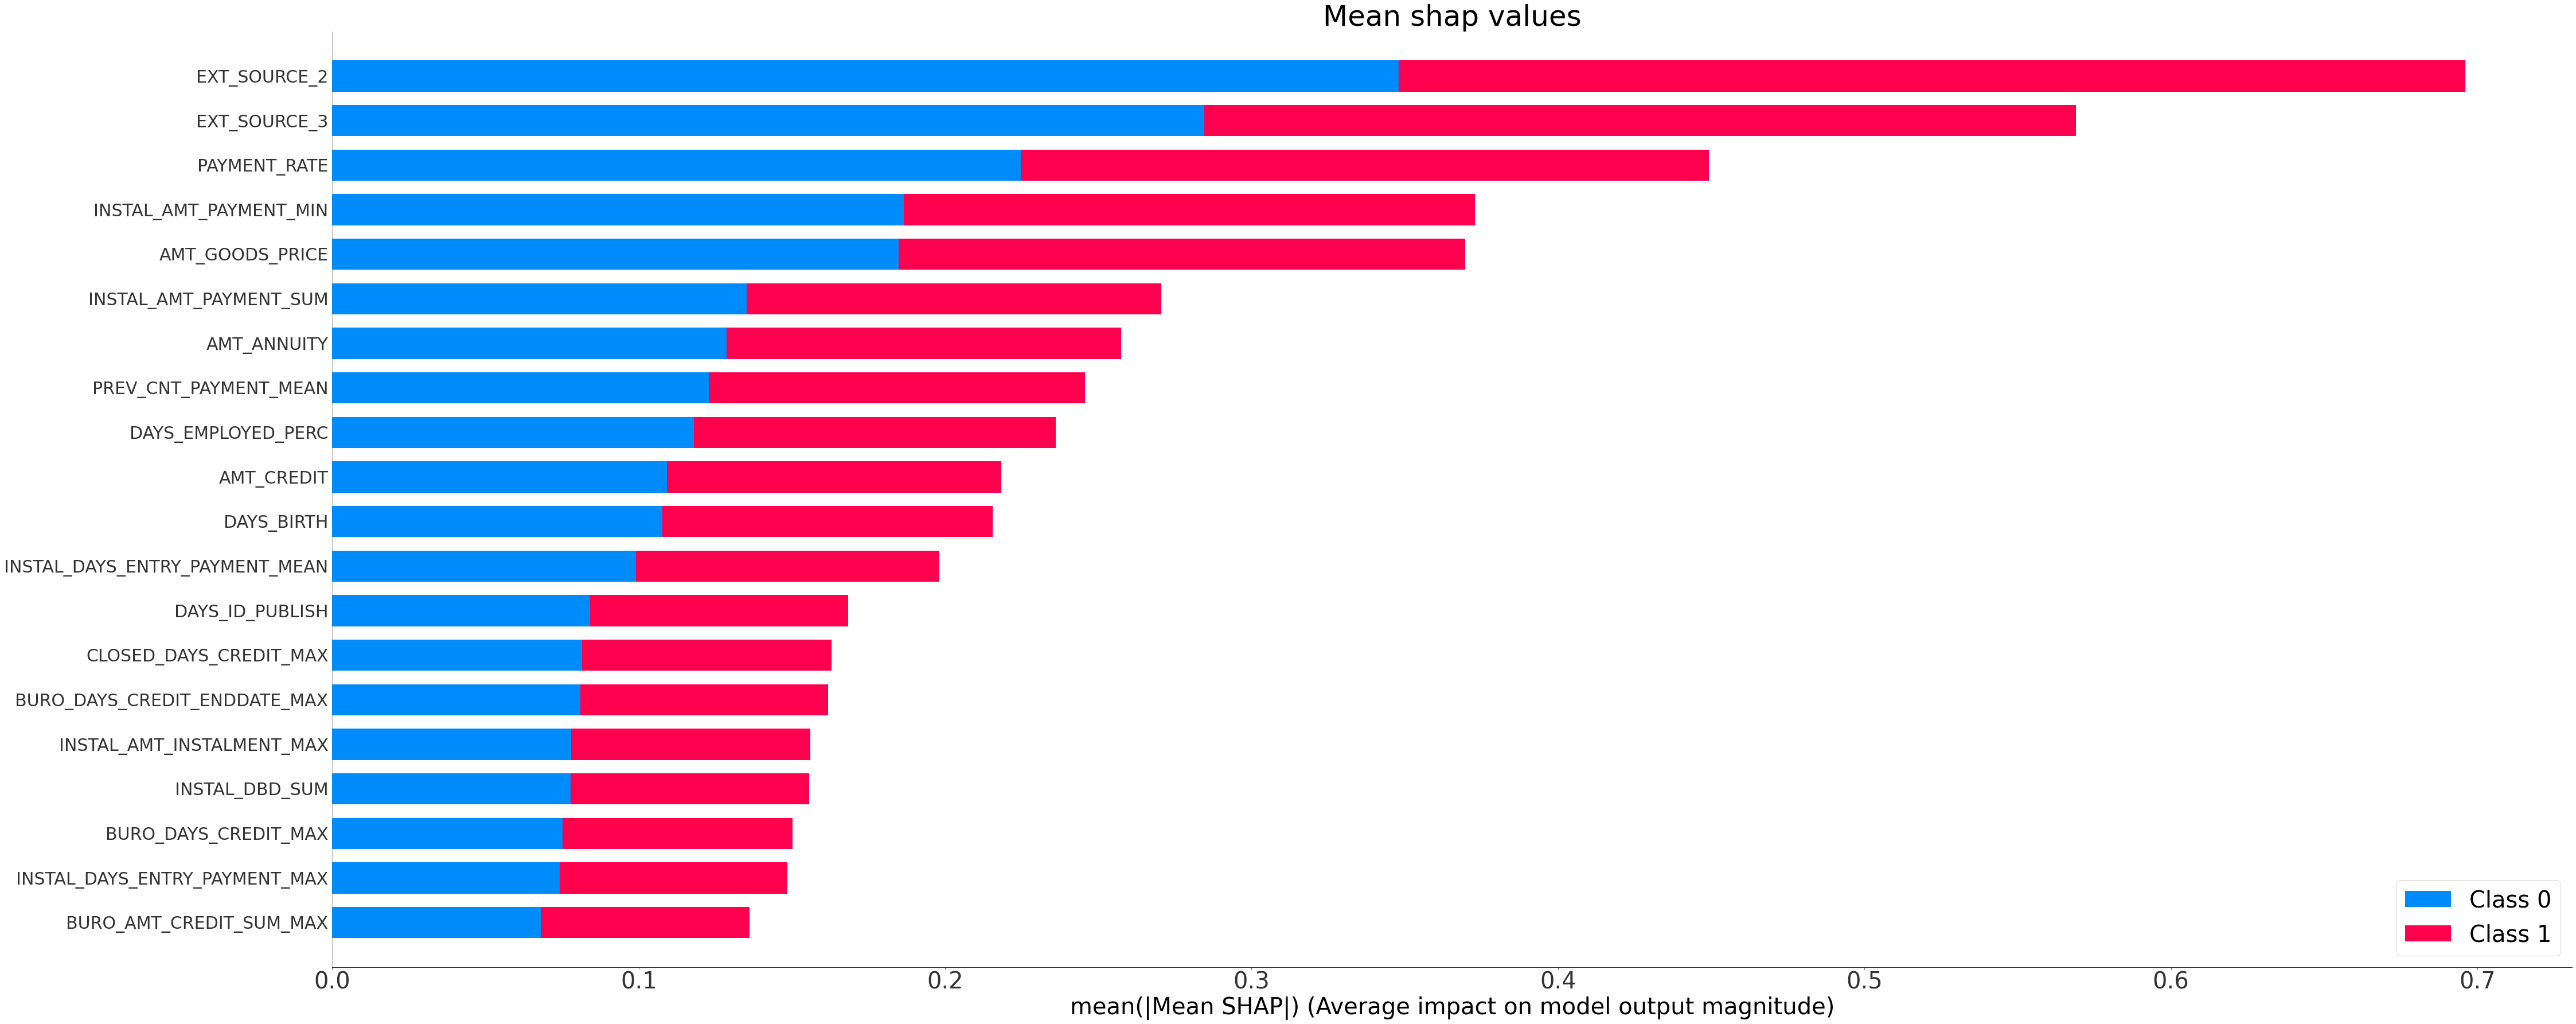

In [97]:
# Average impact
shap.summary_plot(shap_values, df_val_sample, show=False)

# save
fig = plt.gcf()
fig.set_size_inches(70, 30)
plt.title('Mean shap values', fontsize=50)
plt.legend(loc=4, prop={'size': 40})
plt.xticks(fontsize=40)
plt.yticks(fontsize=30)
plt.xlabel('mean(|Mean SHAP|) (Average impact on model output magnitude)', fontsize=40)
fig = plt.gcf()

In [98]:
# Convert fig to image
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img = fig2img(fig)

img.save('projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\with_RFECV\\shap_global_feature_importance.png')

In [100]:
df_val_sample

,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_REGISTRATION,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
286037,0.048105,0.031155,-11000,0.537070,25933.5,0.144075,-2308,450000.0,539100.0,-764.0,...,910.0,-337.0,108.0,15.0,-205.806452,450000.0,13950.000,13950.000,-6380.0,2976.975000
298481,0.050000,0.370512,-10933,0.513694,13500.0,0.150000,-1782,270000.0,270000.0,-5380.0,...,1085.0,-179.0,3.0,2.0,-104.250000,67500.0,25535.745,25535.745,-417.0,25535.745000
159297,0.109912,0.611694,-22790,0.791075,6327.0,0.081272,-4179,54000.0,57564.0,-3717.0,...,-2197.0,-433.0,21.0,7.0,-2818.000000,72900.0,3672.630,3672.630,-19726.0,11966.220000
322930,0.035907,0.760600,-20751,0.504681,10764.0,0.088593,-4303,247500.0,299772.0,-6203.0,...,1652.0,-201.0,418.0,30.0,-739.553571,1800000.0,29246.985,30190.185,-41415.0,17182.755000
148742,0.051627,0.778317,-17585,0.385915,11848.5,0.105320,-1120,229500.0,229500.0,-3143.0,...,1390.0,-792.0,347.0,64.0,-1131.071429,1224729.0,98572.545,98572.545,-31670.0,14025.690000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240148,0.113337,0.644703,-10712,0.490258,28458.0,0.210800,-2912,238500.0,251091.0,-2372.0,...,1067.0,-242.0,473.0,32.0,-1879.903846,479115.0,118273.500,79049.475,-97755.0,16096.853571
309936,0.079174,0.676083,-11954,0.607557,62613.0,0.309200,-3812,675000.0,790830.0,-10135.0,...,1239.0,-17.0,217.0,37.0,-2309.250000,1350000.0,19911.150,19911.150,-27711.0,12150.870000
404630,0.060765,0.645063,-11136,0.508287,23242.5,0.079462,-538,382500.0,382500.0,-2923.0,...,1088.0,-1938.0,195.0,30.0,-1971.305882,1864800.0,55620.000,55620.000,-167561.0,10023.952500


In [101]:
index_lst = list(df_val_sample.index)
len(index_lst)

923

In [102]:
row = index_lst.index(id)
row

922

In [103]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xg_clf)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]], matplotlib = True, show = False)
    plt.savefig('tmp.svg')
    plt.close()
    return(p)

In [104]:
explainer.expected_value[1]

-2.9766582096379857

In [105]:
explainer.shap_values(df_val_sample)[1][row,:]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


array([-0.11498724, -0.17284392,  0.27834653, -0.24127727,  0.24212992,
        0.01603536, -0.30756097, -0.59114652,  0.30819499,  0.03774328,
        0.11241503,  0.45108761, -0.12196768, -0.03802357, -0.22887149,
       -0.10162928, -0.02424114, -0.27249258, -0.05359064, -0.00418964,
       -0.02878658, -0.0796103 , -0.08252018,  0.31177737,  0.00541014,
       -0.30086875,  0.13221258,  0.02085136,  0.1926727 , -0.19256487])

In [106]:
df_val_sample.iloc[row,:]

PAYMENT_RATE                      5.276504e-02
EXT_SOURCE_2                      6.067273e-01
DAYS_BIRTH                       -1.442000e+04
EXT_SOURCE_3                      4.794490e-01
AMT_ANNUITY                       1.657350e+04
ANNUITY_INCOME_PERC               1.364074e-01
DAYS_ID_PUBLISH                  -4.287000e+03
AMT_GOODS_PRICE                   2.250000e+05
AMT_CREDIT                        3.141000e+05
DAYS_REGISTRATION                -4.179000e+03
INSTAL_DAYS_ENTRY_PAYMENT_MAX    -4.170000e+02
PREV_CNT_PAYMENT_MEAN             4.450000e+01
DAYS_LAST_PHONE_CHANGE           -1.077000e+03
DAYS_EMPLOYED_PERC                2.177531e-02
BURO_DAYS_CREDIT_MAX             -9.700000e+01
INSTAL_AMT_PAYMENT_SUM            1.600857e+05
INCOME_CREDIT_PERC                3.868195e-01
INSTAL_AMT_PAYMENT_MIN            5.270085e+03
ACTIVE_DAYS_CREDIT_ENDDATE_MIN    9.990000e+02
CLOSED_DAYS_CREDIT_MAX           -4.440000e+02
BURO_DAYS_CREDIT_ENDDATE_MAX      9.990000e+02
APPROVED_DAYS

In [107]:
# force plot
shap.initjs()
shap.force_plot(explainer.expected_value[1], explainer.shap_values(df_val_sample)[1][row,:], df_val_sample.iloc[row,:], matplotlib=False)